### Evaluación Científico de Datos Jr 

Modelo predictivo que muestre la probabilidad de que un
CLIENTE retire el 70% o más de su saldo en los siguientes 3 meses

-Primer paso
Se realiza la lectura de los saldos y se busca estandarizar la información para un manejo más sencillo de los datos. 
Realizamos una agrupación a nivel ID del cliente para saber su saldo, qué contratos y que productos tiene activos, incluyendo el historial de su saldo mensual

In [20]:
import pyarrow.parquet as pq
import pandas as pd
from datetime import datetime as dt
import numpy as np

saldos = pq.read_table('0saldos.parquet').to_pandas()
saldos = saldos.loc[saldos['TipoDocum'] == 'C ']
# saldos
# Realizar la agrupación y especificar cómo agregar las columnas utilizando regex
# resultados_agrupados = df.groupby('columna_agrupadora').apply(lambda x: x.filter(regex=regex_a_mantener))

info_por_cliente = saldos.groupby('NroDocum').agg(
    Contrato=('Contrato', list),
    # NumeroContratos=('Contrato', 'count'),
    # NumeroProductos=('PlanProducto', 'count'),
    Productos=('PlanProducto', list),
    **{col: (col, 'sum') for col in saldos.columns if
       col not in ['NroDocum', 'Contrato', 'PlanProducto', 'TipoDocum', 'SALDO_202209']}
).reset_index()
# conteo_contratos_por_cliente['Saldo2022Aug'] = conteo_contratos_por_cliente['Saldo2022Aug'].apply(lambda x: list(set(x)))
info_por_cliente['Productos'] = info_por_cliente['Productos'].apply(lambda x: list(set(x)))

info_por_cliente.head(20)

,NroDocum,Contrato,Productos,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,...,SALDO_202112,SALDO_202201,SALDO_202202,SALDO_202203,SALDO_202204,SALDO_202205,SALDO_202206,SALDO_202207,SALDO_202208,SALDO_202210
0,1000001634,[9950268],[4899],47092297.99,46315661.29,45229127.61,45298456.10,47140239.11,4.692357e+07,5.173611e+07,...,5.161528e+07,4.999541e+07,5.090699e+07,4.823857e+07,50249882.12,48430969.50,48976166.48,50399995.40,49148602.10,4.967498e+07
1,1000004345,"[8629082, 6261343, 6133677, 9374655, 5919728]","[3376, 8404]",0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
2,1000005362,[6845989],[7256],0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
3,1000005396,[5835760],[7256],0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
4,1000007479,[2779865],[8404],90932411.58,93993197.01,96553396.47,99759806.09,99628363.77,1.088142e+08,1.089287e+08,...,1.269493e+08,1.304447e+08,1.304298e+08,1.365314e+08,36996395.24,39371555.32,42176765.55,45424357.88,50964795.04,2.548386e+08
5,1000007557,[7095683],[7256],0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
6,1000008577,[4620527],[6803],0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
7,1000008826,"[2712448, 7337966, 5048101]",[7256],0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
8,1000009088,[5863862],[7256],0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
9,1000009152,[6053184],[8404],0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00


Ahora leeremos las transferencias, dado que necesitamos el valor neto de las operaciones por mes, agruparemos la información a nivel mes para tener un historial ordenado.

In [21]:
transferencias = pq.read_table('0transferencias.parquet').to_pandas()
transferencias.drop(
    columns=['Usuario', 'CodDestino', 'CodTipoGiro', 'CodBancoDestinoACH', 'CodBancoSkandia', 'TipoCtaACH', 'TipoOper',
             'EstadoReverso'], inplace=True)
transferencias.sort_values(by='FechaEfectiva', ascending=True, inplace=True)
transferencias.FechaEfectiva = pd.to_datetime(transferencias.FechaEfectiva, format='%Y-%m-%d')

# Agrupar las transacciones por mes y sumar los valores
transferencias = transferencias.groupby(
    [transferencias['Contrato'], transferencias['FechaEfectiva'].dt.to_period('M')], as_index=False
).agg(
    FechaEfectiva=('FechaEfectiva', 'first'),
    ValorTransaccion=('ValorNeto', 'sum'),
    Productos=('PlanProducto', list)
)
transferencias['FechaEfectiva'] = transferencias['FechaEfectiva'].dt.strftime('%Y-%m-01')
transferencias['Productos'] = transferencias['Productos'].apply(lambda x: list(set(x)))
transferencias

transferencias_promedio = transferencias.groupby(
    [transferencias['Contrato']], as_index=False
).agg(
    # FechaEfectiva=('FechaEfectiva', 'first'),
    ValorTransaccion=('ValorTransaccion', 'mean'),
    # Productos=('PlanProducto', list)
)
transferencias_promedio

,Contrato,ValorTransaccion
0,10359,-2.400000e+04
1,11135,1.514032e+08
2,11486,4.206700e+06
3,11595,5.200000e+06
4,11989,-5.500000e+07
...,...,...
23407,9998936,4.387500e+08
23408,9999584,1.449000e+07
23409,9999852,-3.300900e+07
23410,9999884,-3.338484e+07


Al realzar la lectura del registro de clientes, vemos que no coincide con nuestro registro de saldos. Para mantener coherencia en la información eliminaremos las entradas sobrantes.
Realizaremos una fusion entre el dataframe de clientes y saldos. 

In [22]:

clientes = pq.read_table('0clientes.parquet').to_pandas()
clientes = clientes.loc[clientes['TIPODOCUM'] == 'C']
clientes.drop(
    columns=['EnvioExtractos', 'TIPODOCUM'], inplace=True)

missings = list(set(info_por_cliente.NroDocum.drop_duplicates().values) - set(clientes.NroDocum.values))
print(missings)
mask = clientes['NroDocum'].isin(missings)
clientes = clientes[~mask]
info_por_cliente = info_por_cliente.merge(clientes, how="right", left_on=['NroDocum'], right_on=['NroDocum'])
# saldos.drop(
#     columns=[ 'TIPODOCUM', 'FecNacim_x', 'FecNacim_y'], inplace=True)
info_por_cliente.head(15)
# clientes
info_por_cliente.loc[info_por_cliente.Contrato == 10359]


[1070060609, 1199426185, 1105436267, 1067667956, 1191709847, 1168295676, 1114592927]


,NroDocum,Contrato,Productos,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,...,SALDO_202202,SALDO_202203,SALDO_202204,SALDO_202205,SALDO_202206,SALDO_202207,SALDO_202208,SALDO_202210,CIUDAD,FecNacim


Ahora buscaremos casos donde los clientes han retirado el 70% o más de su saldo en los últimos 3 meses.

In [23]:
regex = r'^SALDO'
# columnas que coinciden con el regex y suma a lo largo de las filas
# info_por_cliente['suma_tres_meses'] = info_por_cliente['SALDO_202210'] + info_por_cliente['SALDO_202208'] + info_por_cliente['SALDO_202207']
mask_saldos = info_por_cliente.filter(regex=regex).sum(axis=1).isin([0])
info_por_cliente = info_por_cliente[~mask_saldos]

info_por_cliente['-70%'] = False
info_por_cliente['edad'] = info_por_cliente['FecNacim']
info_por_cliente = info_por_cliente.astype({'edad': 'str'})
info_por_cliente['edad'] = info_por_cliente['edad'].str.slice(0, 4)
info_por_cliente = info_por_cliente.astype({'edad': 'int'})
info_por_cliente['edad'] = -(info_por_cliente['edad'] -2022)
# info_por_cliente.loc[int(info_por_cliente['FecNacim'][0:4]) - 2022 >= (info_por_cliente['SALDO_202206'] * 0.30), '-70%'] = True

info_por_cliente.loc[info_por_cliente['SALDO_202206'] - info_por_cliente['SALDO_202210'] >= (
            info_por_cliente['SALDO_202206'] * 0.30), '-70%'] = True

info_por_cliente = pd.merge(info_por_cliente.explode('Contrato'), transferencias_promedio, on='Contrato', how='left')
# Agrupar por usuario y sumar los números asociados a los contratos
# info_por_cliente = info_por_cliente.groupby('NroDocum')['ValorTransaccion'].sum().reset_index()

info_por_cliente.head(10)
# 1092070504

,NroDocum,Contrato,Productos,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,...,SALDO_202205,SALDO_202206,SALDO_202207,SALDO_202208,SALDO_202210,CIUDAD,FecNacim,-70%,edad,ValorTransaccion
0,1092070504,9568209,[7256],2160283.24,2141898.30,2108735.19,22159134.02,22120000.31,18148702.83,18163726.64,...,15140299.09,15129302.55,15134704.54,15223124.30,13382658.87,"BOGOTA D.C., BOGOTA",1954-12-16,False,68,-2.121244e+06
1,1097627287,4287717,"[7256, 8404]",87443093.98,87471486.70,87011064.12,87222934.80,87119027.32,87263309.38,87369782.91,...,75874782.13,75904347.84,75621538.10,75936631.30,76451290.69,"BOGOTA D.C., BOGOTA",1969-08-04,False,53,NaN
2,1097627287,3578135,"[7256, 8404]",87443093.98,87471486.70,87011064.12,87222934.80,87119027.32,87263309.38,87369782.91,...,75874782.13,75904347.84,75621538.10,75936631.30,76451290.69,"BOGOTA D.C., BOGOTA",1969-08-04,False,53,-6.500000e+06
3,1079454835,9062165,"[7256, 4899]",447349.75,427505.61,402144.49,385543.39,365940.43,347245.96,0.00,...,3217829.75,3226585.30,3235574.81,3253485.28,3300591.72,"BOGOTA D.C., BOGOTA",1986-02-08,False,36,-7.981530e+03
4,1079454835,4126838,"[7256, 4899]",447349.75,427505.61,402144.49,385543.39,365940.43,347245.96,0.00,...,3217829.75,3226585.30,3235574.81,3253485.28,3300591.72,"BOGOTA D.C., BOGOTA",1986-02-08,False,36,-2.368445e+05
5,1079454835,3256033,"[7256, 4899]",447349.75,427505.61,402144.49,385543.39,365940.43,347245.96,0.00,...,3217829.75,3226585.30,3235574.81,3253485.28,3300591.72,"BOGOTA D.C., BOGOTA",1986-02-08,False,36,-2.044631e+04
6,1079454835,2004052,"[7256, 4899]",447349.75,427505.61,402144.49,385543.39,365940.43,347245.96,0.00,...,3217829.75,3226585.30,3235574.81,3253485.28,3300591.72,"BOGOTA D.C., BOGOTA",1986-02-08,False,36,-6.833955e+04
7,1079454835,5060811,"[7256, 4899]",447349.75,427505.61,402144.49,385543.39,365940.43,347245.96,0.00,...,3217829.75,3226585.30,3235574.81,3253485.28,3300591.72,"BOGOTA D.C., BOGOTA",1986-02-08,False,36,3.190650e+06
8,1199126816,8498466,"[7256, 8404]",315.44,315.70,313.20,319.94,318.57,323.47,325.38,...,309.58,293.69,301.28,297.46,298.22,"MEDELLIN, ANTIOQUIA",1981-01-15,False,41,NaN
9,1199126816,730328,"[7256, 8404]",315.44,315.70,313.20,319.94,318.57,323.47,325.38,...,309.58,293.69,301.28,297.46,298.22,"MEDELLIN, ANTIOQUIA",1981-01-15,False,41,NaN


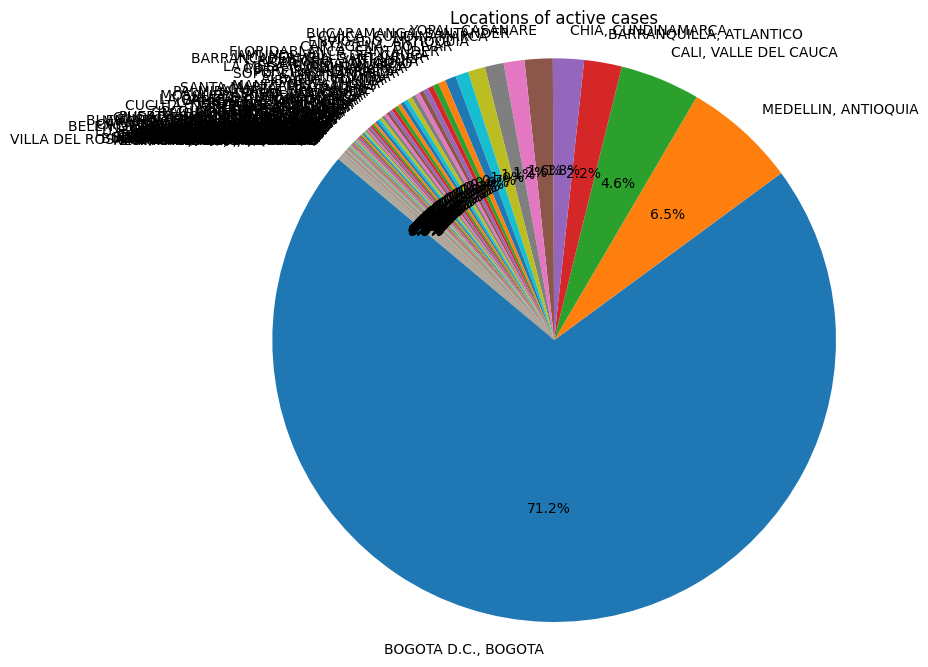

In [24]:
import matplotlib.pyplot as plt

info_por_cliente.loc[info_por_cliente['ValorTransaccion'] < 0, 'Promedio de transacciones'] = -1
info_por_cliente.loc[info_por_cliente['ValorTransaccion'] > 0, 'Promedio de transacciones'] = 1

casos_activos = info_por_cliente.loc[info_por_cliente['-70%'] == True]
# casos_activos.head(10)

# Obtén los valores únicos y sus recuentos de la columna 'columna'
counts = casos_activos['CIUDAD'].value_counts()

# Crea un gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Hace que el gráfico de pastel sea circular
plt.title('Locations of active cases')
plt.show()




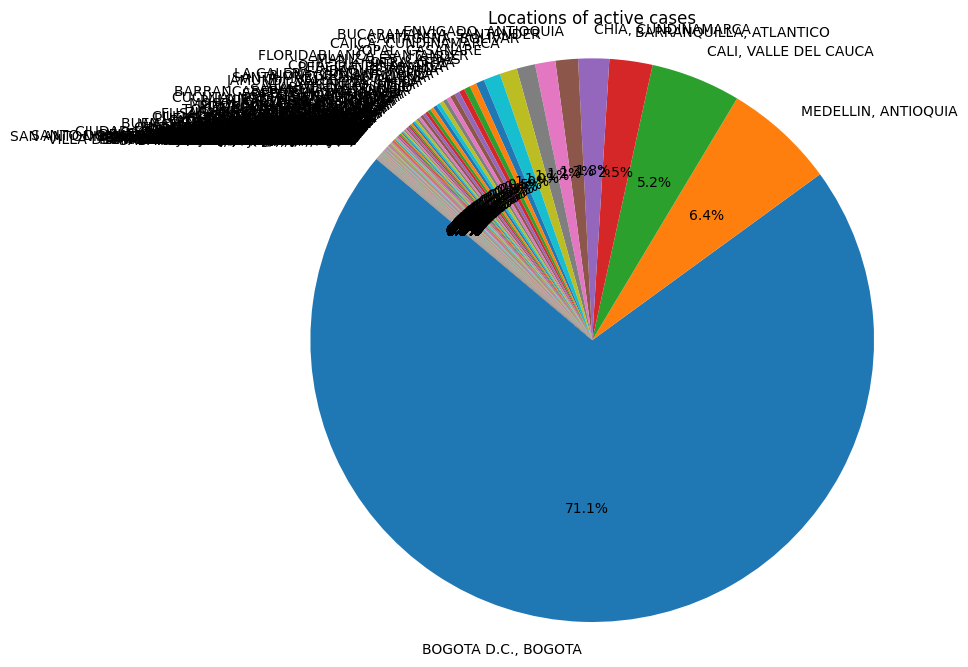

In [25]:
counts = info_por_cliente['CIUDAD'].value_counts()

# Crea un gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Hace que el gráfico de pastel sea circular
plt.title('Locations of active cases')
plt.show()

In [26]:
porcentaje_de_casos = (len(casos_activos.index.values)) / ((len(info_por_cliente.index.values))*0.01 )
print(str(porcentaje_de_casos) +' %')


18.774044241404184 %


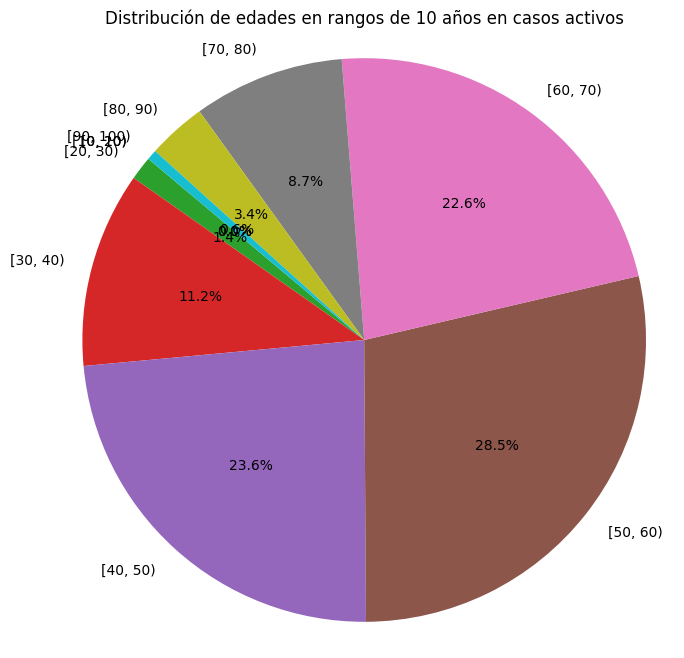

In [27]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

age_groups = pd.cut(casos_activos['edad'], bins=bins, right=False)
age_group_counts = age_groups.value_counts().sort_index()

# Creamos la gráfica de pastel
plt.figure(figsize=(8, 8))
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Hace que el gráfico de pastel sea circular
plt.title('Distribución de edades en rangos de 10 años en casos activos')
plt.show()

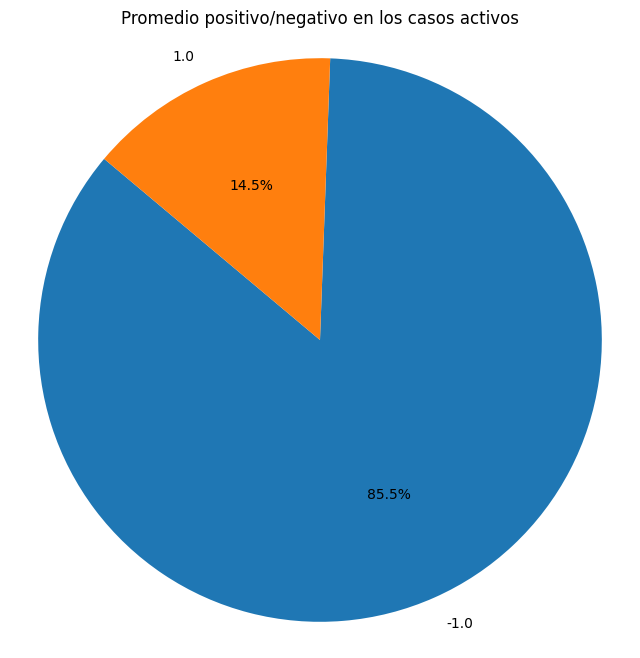

In [28]:
counts = casos_activos['Promedio de transacciones'].value_counts()

# Crea un gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Hace que el gráfico de pastel sea circular
plt.title('Promedio positivo/negativo en los casos activos')
plt.show()

In [29]:
def group_columns_by_regex(row, regex):
    selected_columns = row.filter(regex=regex)
    return selected_columns.tolist()

# Definir el regex para seleccionar las columnas
regex = '^SALDO'

# Aplicar la función a lo largo de las filas del DataFrame para crear la nueva columna
info_por_cliente['Serie Saldos'] = info_por_cliente.apply(lambda row: group_columns_by_regex(row, regex), axis=1)
info_por_cliente.head(10)

# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

# Cargar tus datos (reemplaza esto con tus datos reales)

# Preprocesar los datos
X = info_por_cliente[['edad', 'Serie Saldos']].values
y = info_por_cliente['Serie Saldos'].values

# Dividir los datos en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 
# # Estandarizar las características
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# 
# # Crear el modelo
# model = Sequential()
# model.add(Dense(units=64, activation='relu', input_dim=2))
# model.add(Dense(units=1, activation='sigmoid'))
# 
# # Compilar el modelo
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# 
# # Entrenar el modelo
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# 
# # Evaluar el modelo
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Precisión del modelo: {accuracy:.2f}')
# 
# # Hacer predicciones
# new_data = np.array([[45, 5000]])  # Datos de un nuevo cliente
# prediction = model.predict(new_data)
# print(f'Probabilidad de retiro: {prediction[0][0]:.2f}')
